## Using CNN by PyTorch for classify cats and dogs image

### Import Libaries

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
import os, shutil
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim


### unzip data cats and dogs image

In [2]:
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip -d /kaggle/working/data
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip -d /kaggle/working/data


### Data Loader
#### CNNs require images to be of fixed size and normalized to learn effectively.

In [3]:
train_path = "/kaggle/working/data/train"

# print 10 first file in folder train
print(os.listdir(train_path)[:10])
print("Total file in train:", len(os.listdir(train_path)))


['cat.890.jpg', 'dog.8699.jpg', 'dog.10839.jpg', 'dog.6847.jpg', 'dog.4348.jpg', 'cat.2081.jpg', 'dog.1833.jpg', 'dog.4461.jpg', 'cat.7867.jpg', 'cat.5409.jpg']
Total file in train: 25000


#### Split data into 2 separate dog and cat folders

In [4]:
train_dir = "/kaggle/working/data/train"

# Tạo thư mục con cho từng lớp
os.makedirs(os.path.join(train_dir, "cats"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "dogs"), exist_ok=True)

# Di chuyển ảnh đúng chỗ
for filename in tqdm(os.listdir(train_dir)):
    if filename.endswith(".jpg"):
        if "cat" in filename:
            shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, "cats", filename))
        elif "dog" in filename:
            shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, "dogs", filename))


100%|██████████| 25002/25002 [00:00<00:00, 27456.32it/s]


In [5]:
len(os.listdir("/kaggle/working/data/train/cats")), len(os.listdir("/kaggle/working/data/train/dogs"))


(12500, 12500)

In [6]:
train_path = "/kaggle/working/data/test"

# print 10 first file in folder test
print(os.listdir(train_path)[:10])
print("Total file in test:", len(os.listdir(train_path)))


['8446.jpg', '2647.jpg', '5316.jpg', '4484.jpg', '10846.jpg', '5360.jpg', '1848.jpg', '9450.jpg', '2706.jpg', '11518.jpg']
Total file in test: 12500


In [7]:
# 🔹 Step 1: define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

# 🔹 Step 2: Create dataset by cats & dogs Folder
data_dir = "/kaggle/working/data/train"
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# 🔹 Step 3: Split train/validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 🔹 Step 4: DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 🔹 Step 5: Check result
print(f"Total train image: {len(train_dataset)}")
print(f"Total val image: {len(val_dataset)}")

images, labels = next(iter(train_loader))
print(f"shape image batch: {images.shape}")


Total train image: 20000
Total val image: 5000
shape image batch: torch.Size([32, 3, 224, 224])


#### build model CNN basic

In [12]:


class SimpleCNNPlus(nn.Module):
    def __init__(self):
        super(SimpleCNNPlus, self).__init__()
        
        # --- Convolution Block 1 ---
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)              # Chuẩn hóa theo batch
        self.pool = nn.MaxPool2d(2, 2)
        
        # --- Convolution Block 2 ---
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # --- Convolution Block 3 ---
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # --- Fully Connected ---
        self.fc1 = nn.Linear(128 * 28 * 28, 256)   # sau 3 lần pooling (224→112→56→28)
        self.dropout = nn.Dropout(0.5)             # dropout để tránh overfitting
        self.fc2 = nn.Linear(256, 2)               # 2 lớp: cat, dog

    def forward(self, x):
        # Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(-1, 128 * 28 * 28)
        
        # Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#### Model initialization + training configuration

In [13]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNNPlus().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#### Train

In [14]:
num_epochs = 100
patience = 5  # allowed epoch number does not improve
best_val_loss = float('inf')
trigger_times = 0

for epoch in range(num_epochs):
    # ===== TRAIN =====
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ===== EARLY STOPPING =====
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")  # save best model
    else:
        trigger_times += 1
        print(f"⚠️ No improve ({trigger_times}/{patience})")
        if trigger_times >= patience:
            print("⛔ Early stopping activate!")
            break


Epoch [1/100] | Train Loss: 0.9320 | Val Loss: 0.6193
Epoch [2/100] | Train Loss: 0.6388 | Val Loss: 0.6159
Epoch [3/100] | Train Loss: 0.6255 | Val Loss: 0.5771
Epoch [4/100] | Train Loss: 0.6164 | Val Loss: 0.5462
Epoch [5/100] | Train Loss: 0.5998 | Val Loss: 0.5492
⚠️ No improve (1/5)
Epoch [6/100] | Train Loss: 0.5911 | Val Loss: 0.5473
⚠️ No improve (2/5)
Epoch [7/100] | Train Loss: 0.5768 | Val Loss: 0.5345
Epoch [8/100] | Train Loss: 0.5513 | Val Loss: 0.4601
Epoch [9/100] | Train Loss: 0.5282 | Val Loss: 0.4551
Epoch [10/100] | Train Loss: 0.5028 | Val Loss: 0.4568
⚠️ No improve (1/5)
Epoch [11/100] | Train Loss: 0.4929 | Val Loss: 0.4254
Epoch [12/100] | Train Loss: 0.4763 | Val Loss: 0.4118
Epoch [13/100] | Train Loss: 0.4600 | Val Loss: 0.3769
Epoch [14/100] | Train Loss: 0.4510 | Val Loss: 0.3649
Epoch [15/100] | Train Loss: 0.4267 | Val Loss: 0.3847
⚠️ No improve (1/5)
Epoch [16/100] | Train Loss: 0.4229 | Val Loss: 0.3929
⚠️ No improve (2/5)
Epoch [17/100] | Train Loss: 

#### evaluate model CNN 

In [15]:
best_model = SimpleCNN().to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()
print("✅load best model success!")


✅load best model success!


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


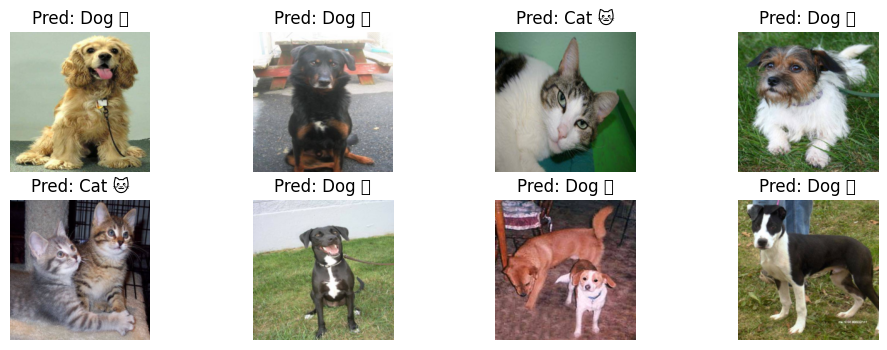

In [16]:


# Get a batch of image from calidation set
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Predict
outputs = best_model(images)
_, preds = torch.max(outputs, 1)

#Show first 8 image
plt.figure(figsize=(12, 4))
for i in range(8):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # set pixel to [0,1]
    label_text = "Dog 🐶" if preds[i] == 1 else "Cat 🐱"
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {label_text}")
    plt.axis('off')
plt.show()


In [ ]:
|